# ImpedanceWakefield: Custom Impedance Functions

The `ImpedanceWakefield` class allows you to create a wakefield model from any user-defined impedance function $Z(k)$. This provides maximum flexibility for implementing custom physics models.

## Physics Background

The longitudinal wakefield $W(z)$ and impedance $Z(k)$ are related by a Fourier transform. For a causal wakefield (defined for $z \le 0$):

$$Z(k) = \frac{1}{c} \int_{-\infty}^{0} W(z) e^{-ikz} dz$$

The inverse relation gives the wakefield from the impedance:

$$W(z) = \frac{2c}{\pi} \int_0^{\infty} \text{Re}[Z(k)] \cos(kz) \, dk \quad (z \le 0)$$

`ImpedanceWakefield` uses FFT-based methods to efficiently compute this transform and apply the wakefield to particle distributions.

## When to Use ImpedanceWakefield

- You have an analytical impedance formula from the literature
- You want to combine multiple impedance contributions (e.g., resistive wall + geometric + CSR)
- You need to implement a custom impedance model not covered by the built-in classes
- You're importing impedance data from another code

## API Summary

| Method | Description |
|--------|-------------|
| `wake(z)` | Evaluate wakefield $W(z)$ via FFT cosine transform |
| `impedance(k)` | Direct evaluation of your impedance function |
| `convolve_density(ρ, dz, plot=False)` | FFT-based density convolution |
| `particle_kicks(z, weight, plot=False)` | Per-particle momentum kicks [eV/m] |

---
## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pmd_beamphysics.wakefields import ImpedanceWakefield, ResistiveWallWakefield
from pmd_beamphysics.units import c_light, Z0

---
## Defining the Impedance Function

The longitudinal impedance for a round resistive wall pipe is (SLAC-PUB-10707 Eq. 2):

$$Z(k) = \frac{Z_0}{2\pi a} \cdot \frac{\zeta(k)}{1 - ik a \zeta(k) / 2}$$

where $a$ is the pipe radius, $Z_0$ is the impedance of free space, and $\zeta(k)$ is the surface impedance:

$$\zeta(k) = (1 - i) \sqrt{\frac{k c}{2 \sigma(k) Z_0 c}}$$

The AC conductivity follows the Drude model:

$$\sigma(k) = \frac{\sigma_0}{1 - i k c \tau}$$

where $\sigma_0$ is the DC conductivity and $\tau$ is the relaxation time.

In [2]:
# Material and geometry parameters (copper, 2.5 mm radius)
a = 2.5e-3  # Pipe radius [m]
sigma0 = 6.5e7  # DC conductivity [S/m]
tau = 27e-15  # Drude relaxation time [s]
ctau = c_light * tau  # Relaxation distance [m]

In [3]:
def ac_conductivity(k):
    """Drude-model AC conductivity."""
    return sigma0 / (1 - 1j * k * ctau)


def surface_impedance(k):
    """Surface impedance for conducting wall."""
    sigma = ac_conductivity(k)
    return (1 - 1j) * np.sqrt(k * c_light / (2 * sigma * Z0 * c_light))


def round_pipe_impedance(k):
    """
    Longitudinal impedance Z(k) for round resistive wall pipe.

    Parameters
    ----------
    k : float or np.ndarray
        Wavenumber [1/m]

    Returns
    -------
    Z : complex or np.ndarray
        Impedance [Ohm/m]
    """
    k = np.asarray(k)

    # Handle k=0 case
    with np.errstate(divide="ignore", invalid="ignore"):
        zeta = surface_impedance(k)
        prefactor = Z0 / (2 * np.pi * a)
        Z = prefactor / (1.0 / zeta - 1j * k * a / 2)
        Z = np.where(k == 0, 0.0 + 0.0j, Z)

    return Z

---
## Creating the ImpedanceWakefield

Simply pass the impedance function to `ImpedanceWakefield`:

In [4]:
wake_custom = ImpedanceWakefield(round_pipe_impedance)
wake_custom

Evaluate impedance at a wavenumber $k$ [1/m]:

In [5]:
wake_custom.impedance(1e5)  # Ω/m

array(41.90384659-59.94765821j)

Evaluate wakefield at a distance $z$ behind the source [V/C/m]:

In [6]:
wake_custom.wake(-10e-6)  # 10 µm behind source

-1593077197930949.8

Both methods are vectorized:

In [7]:
wake_custom.wake([-1e-6, -5e-6, -10e-6, -50e-6])

array([ 5.62796417e+15,  3.12772714e+15, -1.59359536e+15, -1.17194620e+15])

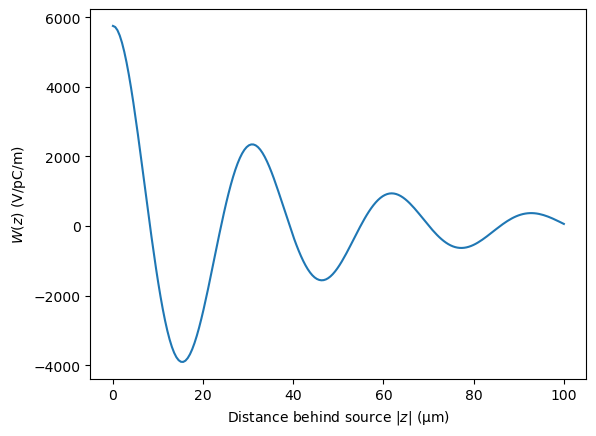

In [8]:
wake_custom.plot(zmax=100e-6)

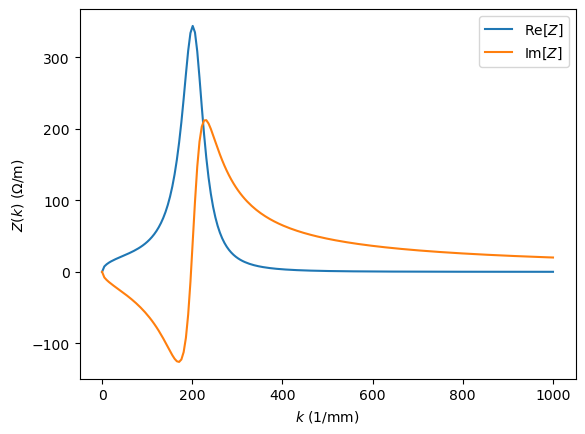

In [9]:
wake_custom.plot_impedance()

---
## Comparison with ResistiveWallWakefield

Create the equivalent built-in model for comparison:

In [10]:
wake_builtin = ResistiveWallWakefield(
    radius=a,
    conductivity=sigma0,
    relaxation_time=tau,
    geometry="round",
)
wake_builtin

ResistiveWallWakefield(radius=0.0025, conductivity=65000000.0, relaxation_time=2.7e-14, geometry='round', material='copper-slac-pub-10707') → s₀=7.992e-06 m

### Compare Impedance Z(k)

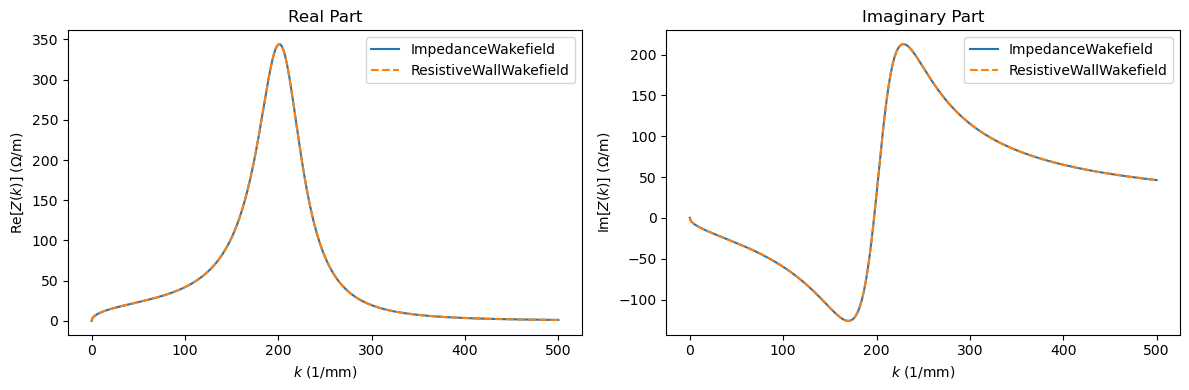

In [11]:
k = np.linspace(0, 5e5, 500)

Z_custom = wake_custom.impedance(k)
Z_builtin = wake_builtin.impedance(k)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(k * 1e-3, np.real(Z_custom), label="ImpedanceWakefield")
ax.plot(k * 1e-3, np.real(Z_builtin), "--", label="ResistiveWallWakefield")
ax.set_xlabel(r"$k$ (1/mm)")
ax.set_ylabel(r"Re[$Z(k)$] (Ω/m)")
ax.set_title("Real Part")
ax.legend()

ax = axes[1]
ax.plot(k * 1e-3, np.imag(Z_custom), label="ImpedanceWakefield")
ax.plot(k * 1e-3, np.imag(Z_builtin), "--", label="ResistiveWallWakefield")
ax.set_xlabel(r"$k$ (1/mm)")
ax.set_ylabel(r"Im[$Z(k)$] (Ω/m)")
ax.set_title("Imaginary Part")
ax.legend()

plt.tight_layout()

In [12]:
# Verify they match numerically
max_diff = np.max(np.abs(Z_custom - Z_builtin))
print(f"Maximum impedance difference: {max_diff:.2e} Ω/m")
assert max_diff < 1e-10, "Impedances should match!"

Maximum impedance difference: 0.00e+00 Ω/m


### Compare Wakefield W(z)

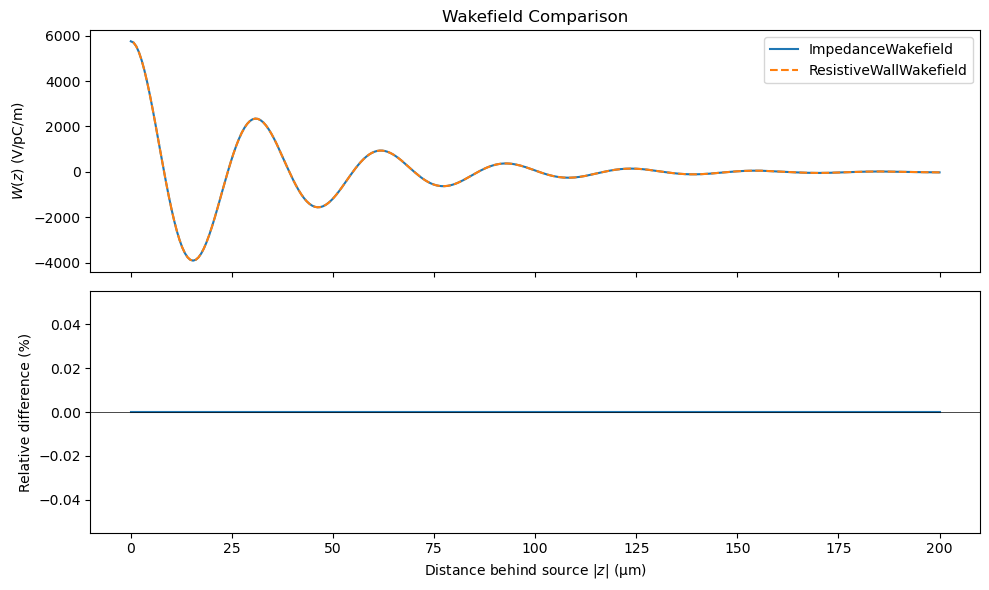

In [13]:
z = np.linspace(-200e-6, 0, 300)

W_custom = wake_custom.wake(z)
W_builtin = wake_builtin.wake(z)

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax = axes[0]
ax.plot(-z * 1e6, W_custom * 1e-12, label="ImpedanceWakefield")
ax.plot(-z * 1e6, W_builtin * 1e-12, "--", label="ResistiveWallWakefield")
ax.set_ylabel(r"$W(z)$ (V/pC/m)")
ax.set_title("Wakefield Comparison")
ax.legend()

ax = axes[1]
rel_diff = (W_custom - W_builtin) / np.abs(W_builtin).max() * 100
ax.plot(-z * 1e6, rel_diff)
ax.set_xlabel(r"Distance behind source $|z|$ (µm)")
ax.set_ylabel("Relative difference (%)")
ax.axhline(0, color="k", lw=0.5)

plt.tight_layout()

In [14]:
# Check agreement
max_rel_diff = np.max(np.abs(rel_diff))
print(f"Maximum relative wakefield difference: {max_rel_diff:.2f}%")

Maximum relative wakefield difference: 0.00%


---
## Applying to Particle Distributions

`ImpedanceWakefield` provides methods to compute momentum kicks from particle distributions.

### Convolving with Charge Density

The `convolve_density` method computes the wake potential from a binned charge density:

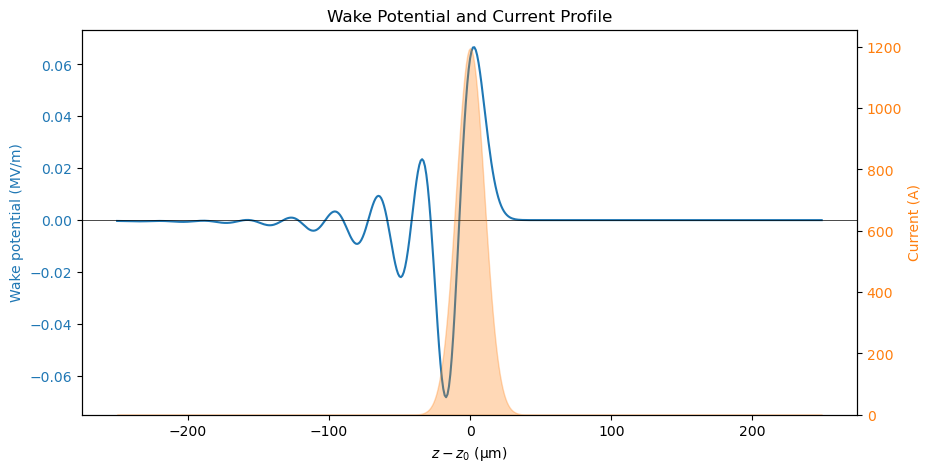

In [15]:
# Create a Gaussian charge density on a grid
n_bins = 500
dz = 1e-6  # Grid spacing [m]
z_grid = np.arange(n_bins) * dz
z0 = z_grid[n_bins // 2]  # Center of distribution

Q_total = 100e-12  # Total charge: 100 pC
sigma_z = 10e-6  # RMS bunch length: 10 µm
density = (
    Q_total
    / (sigma_z * np.sqrt(2 * np.pi))
    * np.exp(-0.5 * ((z_grid - z0) / sigma_z) ** 2)
)

# Convolve with wakefield to get wake potential [V/m]
V = wake_custom.convolve_density(density, dz, plot=True)

### Per-Particle Kicks

The `particle_kicks` method computes the energy kick for each particle based on its position and weight. The visualization shows the charge distribution (blue histogram) and the resulting kicks (orange):

Mean kick: -116.12 keV/m
RMS kick spread: 92.56 keV/m


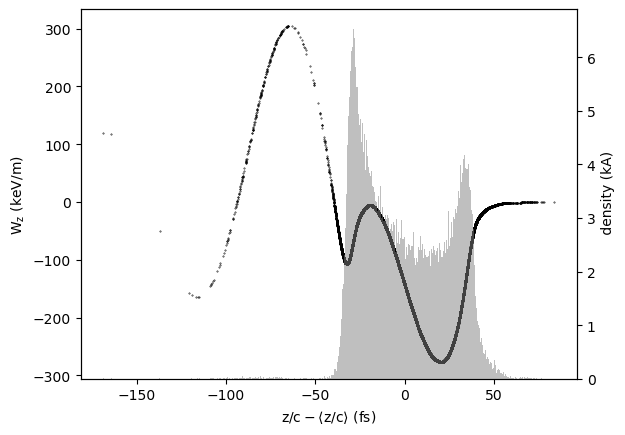

In [16]:
# Load a particle distribution
from pmd_beamphysics import ParticleGroup

P = ParticleGroup("../data/bmad_particles2.h5")
P.drift_to_t()  # Align particles to same time (required for wakefield calculation)

# Compute per-particle kicks [eV/m]
kicks = wake_custom.particle_kicks(P.z, P.weight)
print(f"Mean kick: {np.mean(kicks)/1e3:.2f} keV/m")
print(f"RMS kick spread: {np.std(kicks)/1e3:.2f} keV/m")

# Visualize using ParticleGroup's wakefield_plot method
P.wakefield_plot(wake_custom)

### Applying Wakefield to Particles

The `ParticleGroup.apply_wakefield()` method applies the energy kicks over a specified length and returns a new `ParticleGroup` with modified momenta:

In [17]:
# Apply wakefield over 10 meters of beamline
L = 10.0  # Drift length [m]
P_after = P.apply_wakefield(wake_custom, length=L)

# Compare energy before and after
delta_E = P_after["mean_energy"] - P["mean_energy"]
print(f"Mean energy change over {L} m: {delta_E/1e3:.2f} keV")

Mean energy change over 10.0 m: -1161.22 keV


---
## Summary

`ImpedanceWakefield` allows you to create a wakefield from any impedance function:

```python
def my_impedance(k):
    # Your impedance formula here
    return Z

wake = ImpedanceWakefield(my_impedance)
```

The class provides:
- `wake(z)` - Wakefield via FFT cosine transform (fast for arrays)
- `impedance(k)` - Direct impedance evaluation
- `convolve_density(density, dz)` - FFT-based density convolution
- `particle_kicks(z, weight)` - Per-particle momentum kicks [eV/m]

To apply the wakefield to a `ParticleGroup`:
```python
P_after = P.apply_wakefield(wake, length=L)
```

This is useful for implementing custom impedance models or combining contributions from multiple sources (e.g., resistive wall + geometric + CSR).